# Анализ клиентских анкет фитнес-центра

## Содержание

1) [Описание проекта](#anchor_1)  
2) [Загрузка данных и подготовка их к анализу](#anchor_2)  
3) [Исследовательский анализ данных (EDA)](#anchor_3)  
4) [Модель прогнозирования оттока клиентов](#anchor_4)  
5) [Кластеризация клиентов](#anchor_5)  
6) [Общий вывод и рекомендации](#anchor_6)  

<a id='anchor_1'></a>
## Описание проекта 

**Задача:**

Команда аналитиков сети фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе данных.
Задача любого фитнес-клуба — предупредить отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Наша задача — провести анализ клиентских анкет и подготовить план действий по удержанию посетителей фитнес-центра, а именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов, охарактеризовать их основные свойства;
- определить факторы, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами и их удержанию.

**Цель исследования:**

Спрогнозировать вероятность оттока, обнаружить "группу риска", разработать рекомендации по снижению оттока клиентов.

**Ход исследования:**

*Шаг 1.* Загрузка данных и подготовка их к анализу  
«Культурист-датасаентист» предоставил сведения в csv-файлах. Изучим данные клиентских анкет на месяц до оттока и факт оттока на определённый месяц. Проверим наличие пропусков и дубликатов.

*Шаг 2.* Исследовательский анализ данных (EDA)  
Изучим средние значения и стандартные отклонения (метод describe()).  
Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.  
Изучим распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).  
Отобразим на тепловой карте матрицу корреляций.

*Шаг 3.* Построим модель прогнозирования оттока клиентов  
Построим модель бинарной классификации клиентов с целевым признаком — факт оттока клиента в следующем месяце.  
Разобъём данные на обучающую и валидационную выборку.  
Обучим модель на train-выборке логистической регрессией и методом случайного леса.  
Сравним модели по метрикам accuracy, precision и recall. Определим, какая модель показывает себя лучше на основании метрик.

*Шаг 4.* Кластеризация клиентов  
Проведём кластеризацию объектов (клиентов). Стандартизируем данные. Нарисуем дендрограмму, определим число кластеров.  
На основании алгоритма K-Means обучим модель кластеризации и спрогнозируем кластеры клиентов. Сравним средние значения признаков для кластеров. Для каждого полученного кластера посчитайте долю оттока, определим, какие кластеры склонны к оттоку, а какие — надёжны.

*Шаг 5.* Сформулируем выводы и базовые рекомендации по работе с клиентами  
Подведём итоги исследования и разработаем рекомендации для стратегии взаимодействия с клиентами и их удержания.

---

<a id='anchor_2'></a>
## Загрузка данных и подготовка их к анализу 

Для начала произведём импорт всех необходимых нам библиотек, сделаем некоторые базовые настройки:

In [1]:
# импорт библиотеки pandas
import pandas as pd

#импорт библиотеки numpy для операций с массивами
import numpy as np

# импорт библиотеки для работы с датами
from datetime import datetime, timedelta

# импорт библиотеки визуализации seaborn
import seaborn as sns

# импорт библиотеки matplotlib для продвинутой работы с графиками
import matplotlib.pyplot as plt

# импорт библиотек для построения моделей
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import itertools

# импорт библиотеки для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

# снимем ограничение по ширине граф
pd.set_option('display.max_colwidth', None)

# снимем ограничение по количеству отображаемых строк
pd.set_option('display.max_rows', None)

Прочитаем данные о клиентах фитнес-центра из файла. Выведем на экран 5 случайных строк:

In [2]:
try:
    gym = pd.read_csv('/datasets/gym_churn.csv')
except:
    gym = pd.read_csv('gym_churn.csv')
display(gym.sample(5))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
684,0,0,1,0,1,12,0,27,157.530882,12.0,10,2.345391,2.301679,0
567,1,1,0,0,1,1,0,33,160.056406,1.0,6,2.373122,2.323889,0
3762,1,1,0,1,1,1,1,36,172.742303,1.0,3,2.635485,2.627014,0
1609,1,1,1,1,1,1,0,30,117.061870,1.0,3,0.162850,0.224930,0
265,1,1,0,0,1,12,0,27,212.187203,10.0,3,0.063541,0.000000,0


Согласно документации набор данных включает:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

Посмотрим общую информацию о таблице, воспользовавшись методом *info()*:

In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Итак, в нашем распоряжении оказалась таблица из 14 граф и 4000 строк. Так как количество столбцов небольшое, то нет необходимости проверять наличие пропусков методом *isna()* - их нет.

Для удобства приведем названия столбцов к нижнему регистру:

In [4]:
gym.columns = gym.columns.str.lower()
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Изучим описательную статистику посредством метода *describe()*:

In [5]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Данные выглядят правдоподобно. Не похоже, что среди них есть некорректные или аномально большие/маленькие значения. Средние значения и стандартные отклонения по всем показателям не дают оснований полагать обратное.

Проверим, не содержит ли наша таблица явные дубликаты:

In [6]:
gym.duplicated().sum()

0

Дубликатов в датафрейме не оказалось. Мы произвели краткий обзор данных, можем переходить к исследовательскому анализу.

---

<a id='anchor_3'></a>
## Исследовательский анализ данных (EDA) 

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Факт оттока зашифрован в показателе 'churn', воспользуемся методом *groupby()*:

In [7]:
gym.groupby(by='churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Мы можем видеть, что средние значения показателей по пользователям, которые не ушли в отток ('churn'=0) выше, чем по тем, которые ушли ('churn'=1).

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток). Так как действие предстоит выполнять многократно, обернём его в функцию.

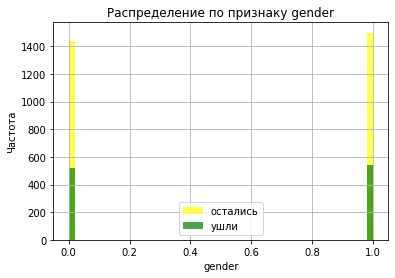

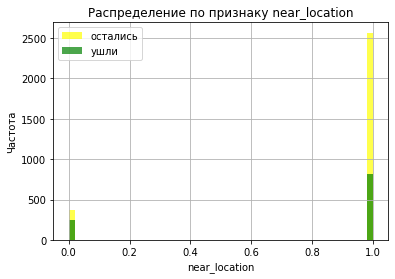

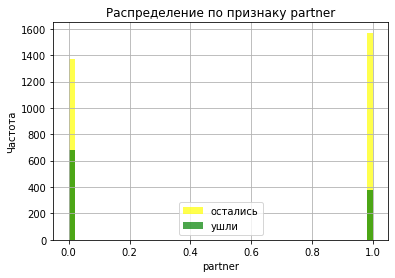

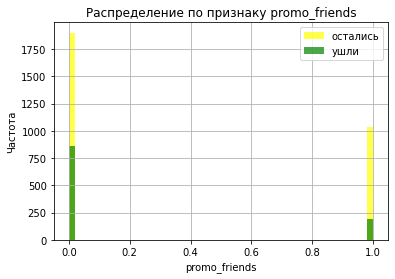

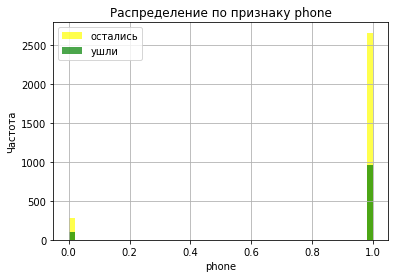

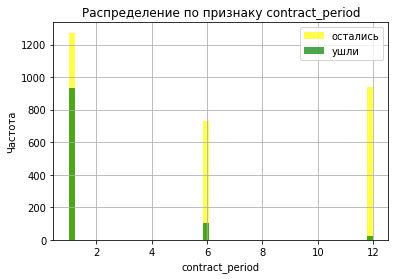

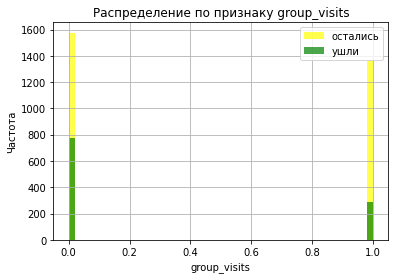

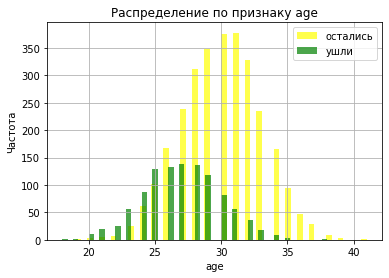

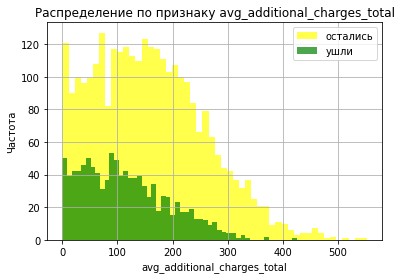

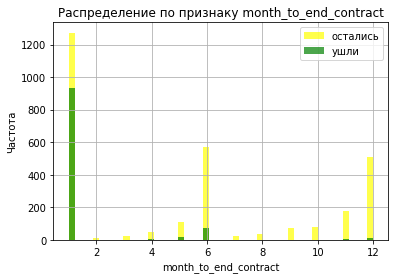

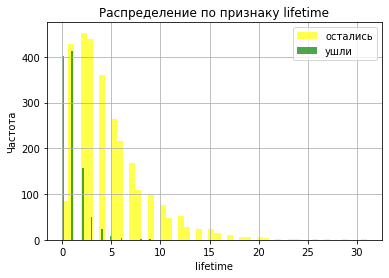

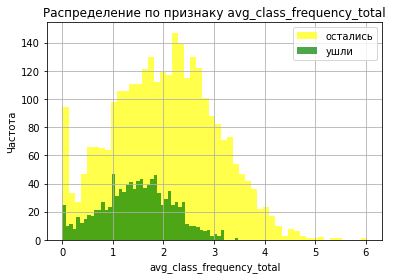

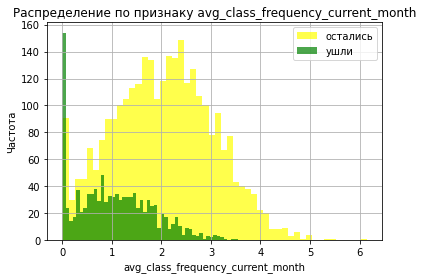

In [8]:
def feature_hist(feature):
    null_feature = gym[gym['churn'] == 0]
    one_feature = gym[gym['churn'] == 1]
    ax = null_feature[feature].plot(bins=50, alpha=0.7, kind='hist', label='остались', legend=True, color='yellow')
    one_feature[feature].plot(
        bins=50, alpha=0.7, ax=ax, kind='hist', label='ушли', grid=True, legend=True, color='green');
    plt.title('Распределение по признаку ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота');

# сформируем список признаков
feature_list = gym.columns
feature_list = feature_list[:-1]

# применим функцию для каждого признака
for i in feature_list:
    feature_hist(i)
    plt.show()

По графикам можем сделать следующие выводы:

- по полу пользователи распределились примерно в одинаковой пропорции в обеих группах,
- большинство оставшихся посетителей проживают или работают в районе, где находится фитнес-центр,
- около двух третей ушедших пользователей не являются сотрудниками компании-партнёра клуба,
- в рамках акции «приведи друга» большинство пользователей остались,
- наличие контактного телефона отмечено у большинства пользователей в обеих группах,
- абонемент на 12 месяцев имеют в основном оставшиеся клиенты,
- посещали групповые занятия по большей части оставшиеся клиенты,
- распределение по возрасту в обеих группах похоже на нормальное, однако оставшиеся клиенты старше в большинстве своем (около 35 лет, а в оттоке наиболее распространенный возраст 25-30 лет),
- суммарная выручка от услуг фитнес-центра заметно выше у оставшихся пользователей,
- у большинства пользователей в обех грппах остался месяц до окончания абонемента,
- время с момента первого обращения в фитнес-центр заметно выше у оставшихся клиентов,
- средняя частота посещений в неделю за предыдущий месяц и за всё время с начала действия абонемента тоже выше у оставшихся клиентов.
    

Посмотрим, какова теснота связи между целевым показателем (факт оттока) и исследуемыми факторами, а также проверим есть ли среди наших факторов мультиколинеарные (наличие таких факторов в модели снижает её качество). Построим матрицу корреляций и отобразим её на тепловой карте:

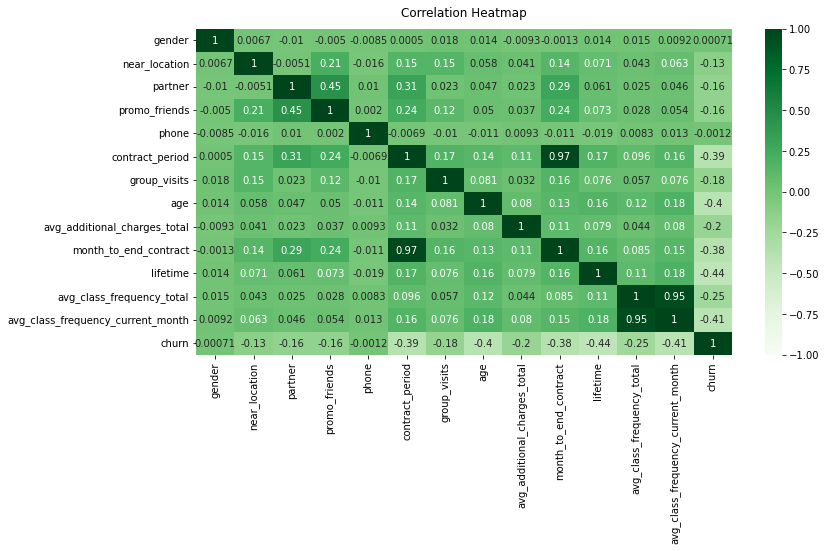

In [9]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(gym.corr(), vmin=-1, vmax=1, annot=True, cmap= 'Greens')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Мы можем заметить, что факт оттока имеет обратную зависимость от исследуемых факторов, однако тесной связи между ними нет. Наибольшим образом на факт оттока влияет средняя частота посещений в неделю за предыдущий месяц, время с момента первого обращения в фитнес-центр и длительность текущего действующего абонемента. Кроме того, у нас имеются мультиколлинеарные факторы: средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента, а также длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента.  
Для улучшения качества модели целесообразно удалить мультиколлинеарные параметры (по одному из каждой пары - contract_period и avg_class_frequency_total). Оставим данные за последний месяц, чтобы модель обучалась на самых актуальных данных (кумулятивную метрику исключим).

In [10]:
gym = gym[['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'group_visits', 'month_to_end_contract', 'age',
       'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month',
       'churn']]
gym.sample(5)

,gender,near_location,partner,promo_friends,phone,group_visits,month_to_end_contract,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
1275,1,1,0,0,1,0,6.0,24,35.855734,3,1.266352,0
2781,1,1,0,0,1,1,1.0,30,185.701699,1,2.173061,0
3245,1,1,0,0,1,0,1.0,27,3.650430,13,3.441129,0
923,0,1,0,0,1,0,1.0,32,173.789725,5,2.997835,0
736,1,1,1,1,1,0,1.0,28,158.872713,2,0.749740,0


Таким образом, мы загрузили данные и подготовили их к анализу. Привели названия граф к хорошему стилю, убедились в отсутствии пропусков и дубликатов. Изучили описательные характеристики и убеделись в отсутствии в данных неправдоподобных значений и выбросов.  
Провели исследовательский анализ данных, сравнили значения параметров по группам клиентов: тех, которые ушли в отток и тех, кто остался. Построили матрицу корреляций. Нашли и устранили из модели мультиколлинеарные факторы.

---

<a id='anchor_4'></a>
## Модель прогнозирования оттока клиентов 

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Разобьем данные на обучающую и валидационную выборку функцией train_test_split(). Обучим модель на train-выборке двумя способами:
логистической регрессией и случайным лесом.
Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Выясним, какая модель показала себя лучше на основании метрик.
Стандартизуем данные для модели логистической регрессии, чтобы убрать шумы расстояний между признаками.

Сначала напишем функцию для вывода метрик для оценки качества моделей:

In [11]:
# определим функцию, которая будет выводить метрики для оценки качества моделей
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

Применим функцию train_test_split из библиотеки sclearn, чтобы выполнить разбиение на обучающую и валидационную выборки. Стандартизуем данные, чтобы улучшить качество моделей:

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1) # сохраним в переменной матрицу объекты-признаки, удалив из датафрейма колонку с целевой переменной
y = gym['churn'] # сохраним в переменной колонку со значением целевой переменной

# разделим модель на обучающую и валидационную выборки в отношении 80% к 20%, зафиксируем параметр random_state
# используем параметр stratify=y - датасет разделится так, чтобы и в трейне и в тесте
# пропорция ушедших\оставшихся клиентов была одинаковой.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационный наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Выполним прогнозы на основании моделей логистической регрессии и случайного леса. Применим функцию для вывода метрик для оценки качества моделей. Сравним модели:

In [13]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=12345)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print('')

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model =  RandomForestClassifier(n_estimators = 100, random_state = 12345)
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.83
	F1: 0.83
	ROC_AUC: 0.97

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.82
	Recall: 0.77
	F1: 0.80
	ROC_AUC: 0.96


Обе модели показывают неплохие метрики. Доля правильных ответов находится на уровне 90-91%. Чтобы выбрать лучшую модель, стоит определиться, которая метрика наиболее важна в нашем случае. Конечная цель - минимизировать отток клиентов. Таким образом, логичнее всего будет опираться на метрику 'recall' (полнота). Она нацелена на минимизацию рисков и показывает, скольно реальных пользователей, попавших в отток, мы смогли обнаружить с помощью модели. Соответственно, наилучшим можно считать прогноз, полученный с помощью модели логистической регрессии. Метрика ROC_AUC (метрика площади под кривой ошибок) в этой модели тоже немного лучше.

---

<a id='anchor_5'></a>
## Кластеризация клиентов

Перед фитнес-центром поставлена задача - минимизировать отток клиентов. Но для начала нам необходимо понять, какие клиенты наиболее склонны к оттоку. Чтобы ответить на данный вопрос, проведём сегментацию клиентов при помощи кластеризации.  
Отложим в сторону столбец с оттоком и проведём кластеризацию объектов (клиентов):

- стандартизируем данные,
- построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков,
- нарисуем дендрограмму.

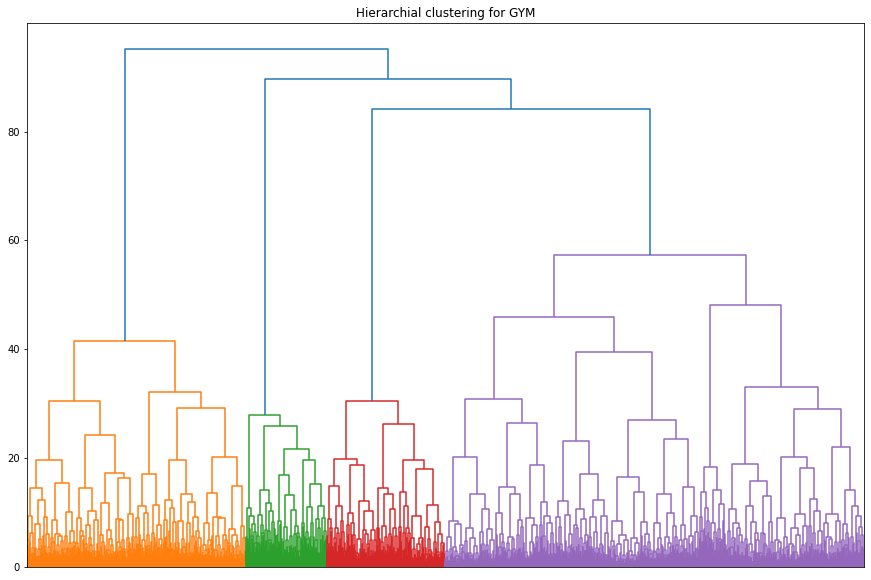

In [14]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True) # уберем ярлыки, чтобы сократить время построения дендрограммы
plt.title('Hierarchial clustering for GYM')
plt.show()

На основании полученного графика можно выделить 4-5 кластеров, остановимся на 5. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

Посмотрим на средние значения признаков для кластеров:

In [15]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=12345)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym['cluster_km'] = labels

# выведем количество пользователей, попавших в каждый кластер
print('Количество пользователей в каждом кластере:')
print(gym.groupby(['cluster_km']).count()['churn'])

# выводим статистику по средним значениям наших признаков по кластеру
gym.groupby(['cluster_km']).mean().T

Количество пользователей в каждом кластере:
cluster_km
0    1022
1     558
2    1046
3     988
4     386
Name: churn, dtype: int64


cluster_km,0,1,2,3,4
gender,0.544031,0.500000,0.490440,0.496964,0.523316
near_location,0.996086,0.000000,1.000000,0.995951,0.862694
partner,0.374755,0.489247,0.219885,0.889676,0.471503
promo_friends,0.009785,0.078853,0.070746,1.000000,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
group_visits,0.522505,0.232975,0.289675,0.523279,0.427461
month_to_end_contract,5.548924,2.818996,1.990440,6.316802,4.466321
age,30.690802,28.679211,27.547801,29.599190,29.297927
avg_additional_charges_total,178.391899,137.125763,116.199081,153.576538,144.208179
lifetime,5.388454,2.974910,1.893881,4.281377,3.940415


Среднее значение по показателю 'churn' характеризует долю пользователей из определённого кластера, которые по нашему прогнозу уйдут в отток. Таким образом, мы можем сравнить их и выявить "группу риска". Самым "оттоковым" у нас оказался второй кластер - 57.2% пользователей этой группы по прогнозу уйдут в отток, что почти 600 человек. Самым "надёжным" показал себя нулевой кластер - отток здесь меньше 2%. Первый, третий и четвертый кластеры демонстрируют средний уровень оттока. Работу с данными клиентами следует ставить приоритетной задачей, так как на их отток больше шансов повлиять/снизить.  
Чтобы  понять, какие пользователи составляют каждый кластер, кроме средних характеристик, посмотрим ещё и модальные - больше половины пользователей каждого кластера будут иметь такой "портрет":

In [16]:
gym.groupby(['cluster_km']).median().T

cluster_km,0,1,2,3,4
gender,1.000000,0.500000,0.000000,0.000000,1.000000
near_location,1.000000,0.000000,1.000000,1.000000,1.000000
partner,0.000000,0.000000,0.000000,1.000000,0.000000
promo_friends,0.000000,0.000000,0.000000,1.000000,0.000000
phone,1.000000,1.000000,1.000000,1.000000,0.000000
group_visits,1.000000,0.000000,0.000000,1.000000,0.000000
month_to_end_contract,6.000000,1.000000,1.000000,6.000000,1.000000
age,31.000000,29.000000,28.000000,30.000000,29.000000
avg_additional_charges_total,170.979057,124.210124,102.025891,148.235441,137.016545
lifetime,4.000000,2.000000,1.000000,3.000000,3.000000


Итак, получаем, что наш "грустный" второй кластер преимущественно составляют новые клиенты (месяц обслужаются в фитнес-центре) 28 лет, у которых остался месяц до окончания абонемента, с посещаемостью раз в неделю. Кроме того, данные пользователи тратят фитнес-центре меньше денег, чем представители других кластеров. Самую надёжную группу составляют постоянные клиенты (на обслуживании фитнес-центра 4 месяц) 31 года, с активным абонементом в течение ещё полугода и посещаемостью больше двух раз в неделю. Закономерно, данные клиенты оставляют в фитнес-центре больше денег.

Построим распределения признаков для кластеров:

Распределение признака gender по кластерам


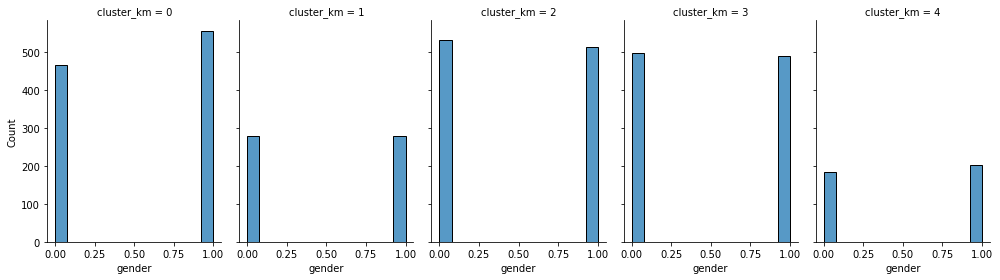

Распределение признака near_location по кластерам


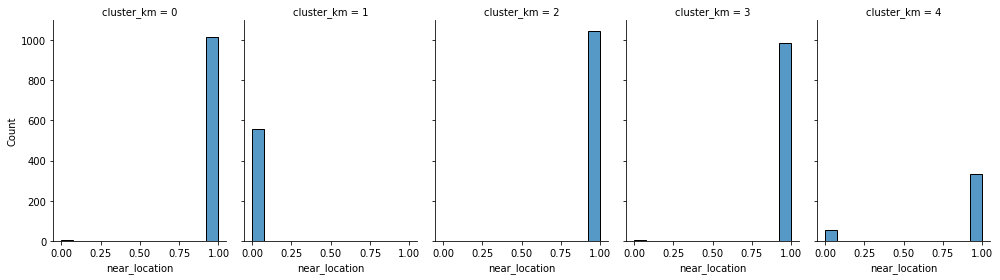

Распределение признака partner по кластерам


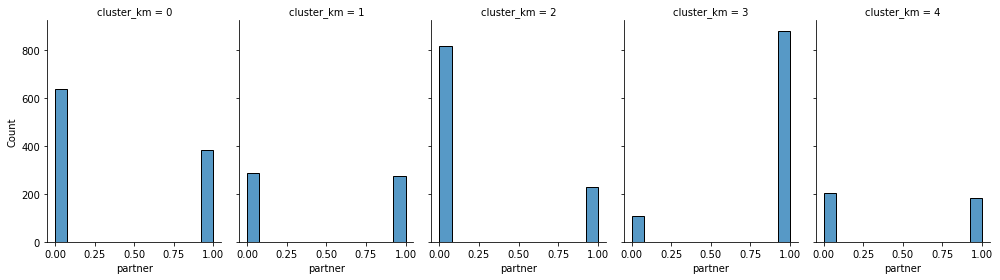

Распределение признака promo_friends по кластерам


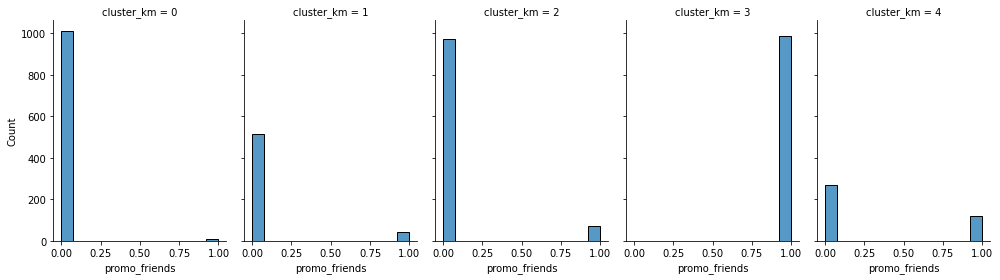

Распределение признака phone по кластерам


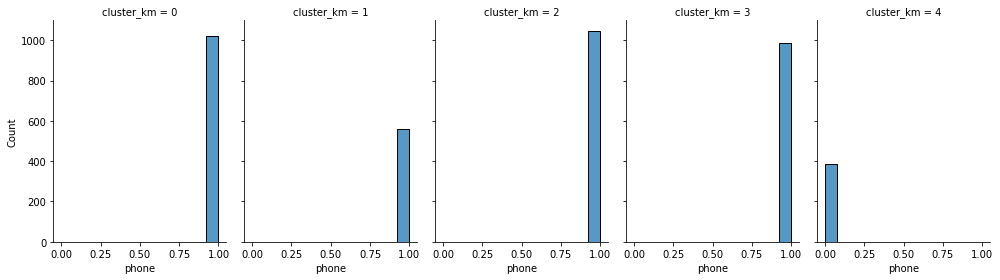

Распределение признака group_visits по кластерам


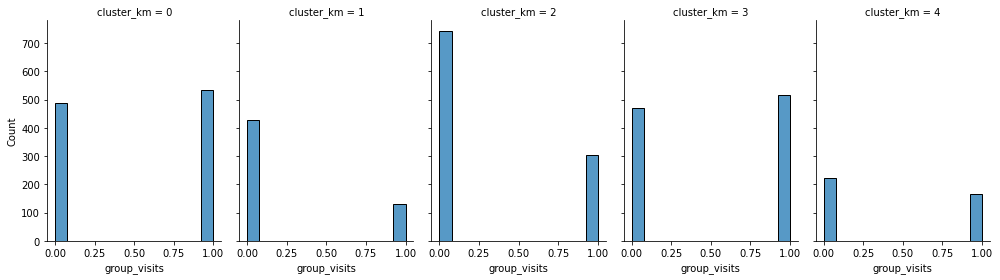

Распределение признака month_to_end_contract по кластерам


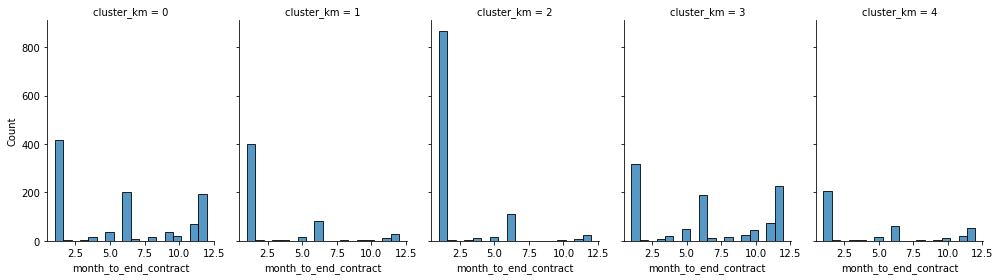

Распределение признака age по кластерам


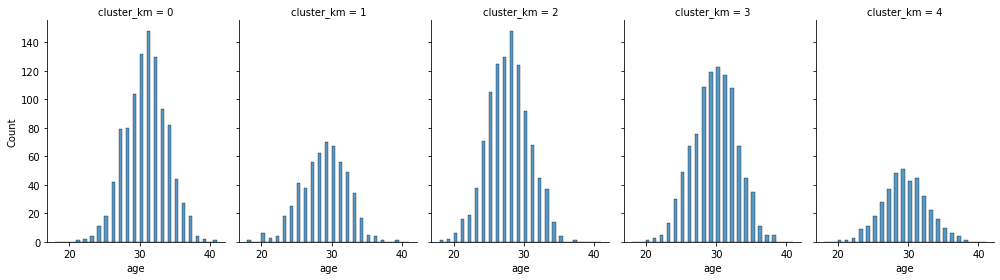

Распределение признака avg_additional_charges_total по кластерам


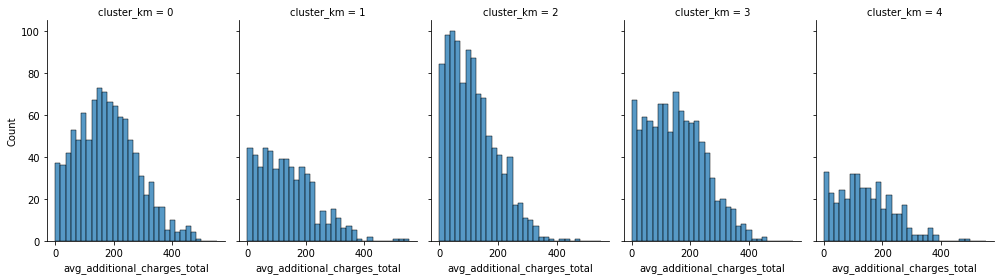

Распределение признака lifetime по кластерам


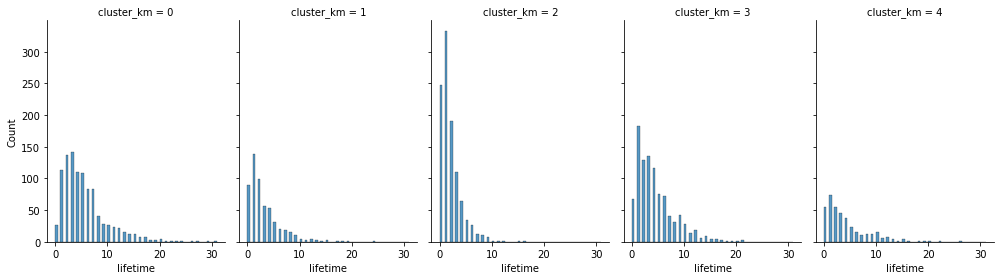

Распределение признака avg_class_frequency_current_month по кластерам


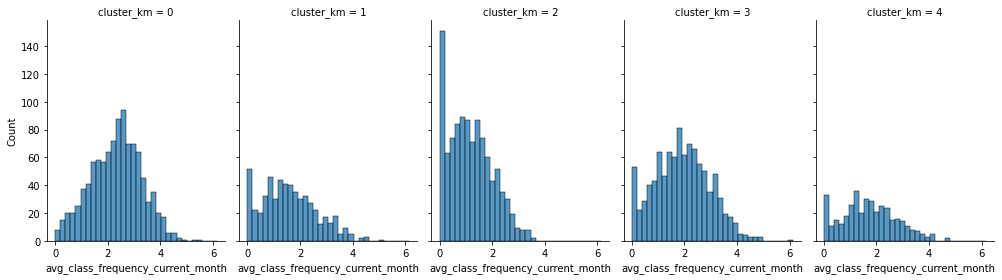

In [17]:
# функция для построения графиков распределения признаков по кластерам
def get_hist(x, group, key_cols):
    x_new = x.copy()
    x_new[key_cols] = gym[key_cols]
    for c in key_cols[:-2]:
        print('Распределение признака {} по кластерам'.format(c))
        sns.displot(data=x_new, x=x_new[c], col='cluster_km', height=4, aspect=0.7)
        plt.show()
 
get_hist(gym, 'cluster_km', gym.columns)

По гистограммам мы можем видеть, как распределяются признаки пользователей внутри каждого кластера. Например, примерно в равной пропорции мужчины и женщины распределились по всем кластерам. Наиболее подверженные оттоку пользователи второго кластера реже других являются сотрудниками компании-партнёра клуба, а также у подавляющего большинства из них абонемент истекает через месяц. Распределения клиентов по возрасту во всех кластерах похожи. Распределение суммарной выручки от других услуг фитнес-центра во всех кластерах имеют схожие черты, но во втором кластере имеет большее смещение в сторону меньших значений. Единственный из всех кластеров второй кластер имеет явный выброс в районе нулевого значения по показателю частоты посещений в неделю.

Посчитаем для каждого полученного кластера долю оттока, выразим её в %:

In [18]:
cluster = gym.groupby('cluster_km').agg({'churn':'mean'})
cluster['churn'] = cluster['churn']*100
cluster.style.format({'churn':'{:.2f}%'})

,churn
cluster_km,
0,1.66%
1,40.32%
2,57.17%
3,11.94%
4,26.68%


У нас образовался своеобразный рейтинг надёжности групп пользователей. Самые надёжные клиенты сформировали нулевой кластер, процент оттока здесь не превышает 2%. Чаще других оттоку подвержены пользователи из второго кластера - больше половины клинтов покидают фитнес-центр. Клиенты первого, второго и четвертого кластеров не обладают высокой слонностью к оттоку. С ними следует работать первоочерёдно в направлении минимизации показателей оттока.

---

## Общий вывод и рекомендации 
<a id='anchor_6'></a>

Мы провели анализ клиентских анкет фитнес-центра.

Загрузили данные и подготовили их к анализу. Убедились в отсутствии пропусков, дубликатов, неправдоподобных значений и выбросов. Провели исследовательский анализ данных, сравнили значения параметров по группам клиентов: тех, которые ушли в отток и тех, кто остался. Построили матрицу корреляций. Нашли и устранили из модели мультиколлинеарные факторы.

Далее спрогнозировали отток клиентов двумя моделями: логистической регрессии и случайного леса. Обе модели показывают неплохие метрики (рассчитали accuracy, precision, recall, F1, ROC_AUC). Доля правильных ответов находится на уровне 90-91%. Чтобы выбрать лучшую модель, стоит определиться, которая метрика наиболее важна в нашем случае. Конечная цель - минимизировать отток клиентов. Таким образом, логичнее всего будет опираться на метрику 'recall' (полнота: 0.83 по модели логистической регрессии против 0.77 по модели случайного леса). Она нацелена на минимизацию рисков и показывает, сколько реальных пользователей, попавших в отток, мы смогли обнаружить с помощью модели. Соответственно, наилучшим можно считать прогноз, полученный с помощью модели логистической регрессии.

Провели сегментацию клиентов при помощи кластеризации. Построив дендрограмму, приняли решение разбить всех пользователей на 5 групп. Рассчитали средние значения показателей, а также долю оттока пользователей в каждом кластере. Выявили группу самых надёжных клиентов, а также группу риска.

В качестве рекомендации предлагаем принимать активные меры по удержанию клиентов, составивших три остальных кластера (процент оттока не сильно велик, на него бльше шансов повлиять). Можно запустить для этих пользователей следующие маркетинговые кампании:
- предоставить скидку на другие услуги фитнес-центра при продлении абонемента;
- предложить бесплатное тестовое занятие с инструктором;
- предоставить в качестве подарка брендированную продукцию с логотипом фитнес-центра;
- разработать дисконт-предложения вместе с компаниями-партнёрами клуба и др.

---